In [1]:
from CoLoRe_corrf_analysis.plot_methods import Plots
from CoLoRe_corrf_analysis.file_funcs import FileFuncs
from CoLoRe_corrf_analysis.fitter import Fitter
from CoLoRe_corrf_analysis.read_colore import ComputeModelsCoLoRe

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [3]:
source1=4
rsd1=True
bias1=1.1 # Set to None if you want to read it from bz file


# Set all 2nd properties to None if you want auto-correlations
source2=5
rsd2=True
bias2=1.5

assert source2 >= source1 # The analysis folder is sorted
assert (source2==None)==(rsd2==None)
if (source2==None) and (bias2!=None):
    raise ValueError('Bias != None in autocorrelation will give wrong results!')

In [4]:
basedir = Path('/global/cscratch1/sd/cramirez/NBodyKit/cross_correlations/multibias')
if source2!=None:
    boxes_path = basedir / f's{source1}_s{source2}'
else:
    boxes_path = basedir / f's{source1}/analysis'

In [5]:
print(FileFuncs.get_available_runs(boxes_path))

+-------+-------------+------+------+--------+------+------+----+
| nside |     rsd     | rmin | rmax | N_bins | zmin | zmax | N  |
+-------+-------------+------+------+--------+------+------+----+
|   2   |  rsd_norsd  | 0.1  | 200  |   41   | 0.5  | 0.7  | 46 |
|   2   | norsd_norsd | 0.1  | 200  |   41   | 0.5  | 0.7  | 48 |
|   2   |   rsd_rsd   | 0.1  | 200  |   41   | 0.5  | 0.7  | 48 |
+-------+-------------+------+------+--------+------+------+----+


In [6]:
zmin=0.5
zmax=0.7

Theory object for the first source.

In [7]:
theory_path = Path('/global/cscratch1/sd/damonge/CoLoRe_sims/sim_bs_1000')
bias_filename = Path(f'/global/cscratch1/sd/cramirez/NBodyKit/multibias/input_files/Bz_s{source1}.txt')
nz_filename=Path('/global/cscratch1/sd/cramirez/NBodyKit/hanyu_david_box/input_files/NzBlue.txt')
pk_filename=Path('/global/cscratch1/sd/cramirez/NBodyKit/hanyu_david_box/input_files/Pk_CAMB_test.dat')

theory = ComputeModelsCoLoRe(
    box_path=theory_path,
    source=source1,
    nz_filename=nz_filename,
    pk_filename=pk_filename,
    param_cfg_filename='/global/cscratch1/sd/damonge/CoLoRe_sims/sim1000/out_params.cfg', #I need this to read the cosmological parameters
    bias_filename=bias_filename,
    apply_lognormal=True)

z=theory.get_zeff(zmin=zmin, zmax=zmax)

if bias1 == None:
    bias1 = theory.bias(z)

if bias2==None and source2!=None:
    bias_filename2=bias_filename.parent / f'Bz_s{source2}.txt'
    theory2 = ComputeModelsCoLoRe(
        box_path=theory_path,
        source=source2,
        nz_filename=nz_filename,
        pk_filename=pk_filename,
        param_cfg_filename='/global/cscratch1/sd/damonge/CoLoRe_sims/sim1000/out_params.cfg', #I need this to read the cosmological parameters
        bias_filename=bias_filename2,
        apply_lognormal=True)
    bias2=theory2.bias(z)

Getting **sub_boxes** with data: (sub_boxes because we handle pixes independently, 1 pixel = 1 sub_box)

In [8]:
sub_boxes = FileFuncs.mix_sims(
    FileFuncs.get_full_path(boxes_path,
                            rsd=rsd1, rsd2=rsd2, #Must specify here rsd2 
                            rmin=0.1, rmax=200, N_bins=41,
                            zmin=zmin, zmax=zmax, #Also results for 0.7 and 0.9
                            nside=2)
)

len(sub_boxes)

48

/global/homes/c/cramirez/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/global/homes/c/cramirez/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "
/global/homes/c/cramirez/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/global/homes/c/cramirez/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-package

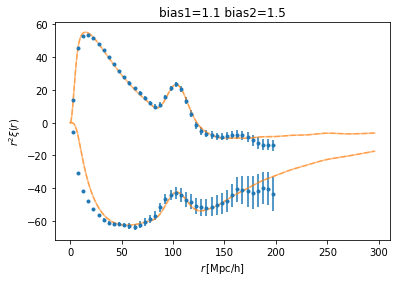

In [9]:
fig, ax = plt.subplots()
pole=2
Plots.plot_data(pole, sub_boxes, ax=ax, plot_args=dict(c='C0'))
Plots.plot_theory(pole, z=z, theory=theory, ax=ax, bias=bias1, bias2=bias2, rsd=rsd1, rsd2=rsd2, plot_args=dict(alpha=0.5, c='C1'))
pole=0
Plots.plot_data(pole, sub_boxes, ax=ax, plot_args=dict(c='C0'))
Plots.plot_theory(pole, z=z, theory=theory, ax=ax, bias=bias1, bias2=bias2, rsd=rsd1, rsd2=rsd2, plot_args=dict(alpha=0.5, c='C1'))
ax.set_title(f'bias1={bias1} bias2={bias2}');

In [12]:
fitter = Fitter(boxes=sub_boxes, z=z, theory=theory, poles=[0, 2], rsd=rsd1, rsd2=rsd2,
                bias0=bias1, bias20=bias2, smooth_factor0=1, smooth_factor_rsd0=1, smooth_factor_cross0=1)

fitter.run_fit(free_params=['bias','bias2'])

/global/homes/c/cramirez/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/global/homes/c/cramirez/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


/global/homes/c/cramirez/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/global/homes/c/cramirez/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


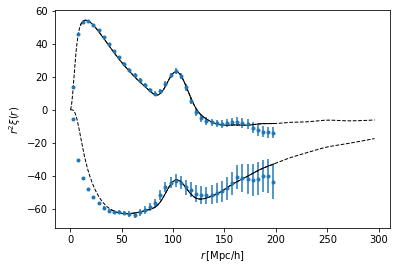

In [13]:
fig, ax = plt.subplots()
pole=2

Plots.plot_data(pole=pole, boxes=sub_boxes, ax=ax, plot_args=dict(c='C0', label='data'))
Plots.plot_best_fit(fitter=fitter, pole=pole, ax=ax, plot_args=dict(c='k', lw=1, label='best fit'))

pole=0

Plots.plot_data(pole=pole, boxes=sub_boxes, ax=ax, plot_args=dict(c='C0', label='data'))
Plots.plot_best_fit(fitter=fitter, pole=pole, ax=ax, plot_args=dict(c='k', lw=1, label='best fit'))

Note how we are getting the disgusting behaviour at low scales in the quadrupole.